In [2]:
import os
import json
import time
import pandas as pd
import itertools
from tqdm.notebook import tqdm
import networkx as nx # the main libary we will use
from networkx.algorithms import bipartite
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit 
import numpy as np
from collections import OrderedDict
from operator import itemgetter



In [130]:
df_auth = pd.read_csv('2010_2020_weighted_edges.csv')

In [131]:
for year in df_auth.year.unique():
    if year == 2010:
        G_2010 = nx.from_pandas_edgelist(df_auth[df_auth.year == year],'Source','Target', edge_attr='weight')
    elif year == 2013:
        G_2013 = nx.from_pandas_edgelist(df_auth[df_auth.year == year],'Source','Target', edge_attr='weight')
    elif year == 2016:
        G_2016 = nx.from_pandas_edgelist(df_auth[df_auth.year == year],'Source','Target', edge_attr='weight')
    elif year == 2019:
        G_2019 = nx.from_pandas_edgelist(df_auth[df_auth.year == year],'Source','Target', edge_attr='weight')
    


In [71]:
print ('G_2010:')
print (nx.info(G_2010))
print ('G_2013:')
print (nx.info(G_2013))
print ('G_2016:')
print (nx.info(G_2016))
print ('G_2019:')
print (nx.info(G_2019))

G_2010:
Name: 
Type: Graph
Number of nodes: 359383
Number of edges: 832372
Average degree:   4.6322
G_2013:
Name: 
Type: Graph
Number of nodes: 455658
Number of edges: 1146028
Average degree:   5.0302
G_2016:
Name: 
Type: Graph
Number of nodes: 560265
Number of edges: 1589391
Average degree:   5.6737
G_2019:
Name: 
Type: Graph
Number of nodes: 613406
Number of edges: 1764452
Average degree:   5.7530


In [72]:
def degree_probs_by_year(G_dict):
    degree_probs = dict()
    
    for key in G_dict.keys():
        degree_hist = nx.degree_histogram(G_dict[key]) 
        degree_hist = np.array(degree_hist, dtype=float)
        degree_prob = degree_hist/G_dict[key].number_of_nodes()
        degree_probs[key] = degree_prob
    
    return degree_probs
    
    

In [73]:
degree_probs = degree_probs_by_year({'2010': G_2010, '2013':G_2013, '2016':G_2016, '2019':G_2019})

## Degree, Average Degree and Degree Distribution

In [74]:
def plot_degree_dist_from_dict(degree_probs):
    labels=[]
       
    colors_lst = ['b.', 'g.', 'y.', 'r.', 'k.']
    fig = plt.figure(figsize=(6,6))
    axes = fig.add_axes([1,1,1,1])
    i=0   
    for key in degree_probs.keys():
        axes.loglog(np.arange(degree_probs[key].shape[0]), degree_probs[key], colors_lst[i], 
                    markersize=15, alpha=0.5)
        labels.append(key)
        
        i+=1
        
    axes.legend(labels)
    axes.set_xlabel('k')
    axes.set_ylabel('p(k)')
    axes.set_title('Degree Distribution')
    
    plt.show()
    
    return degree_probs
        

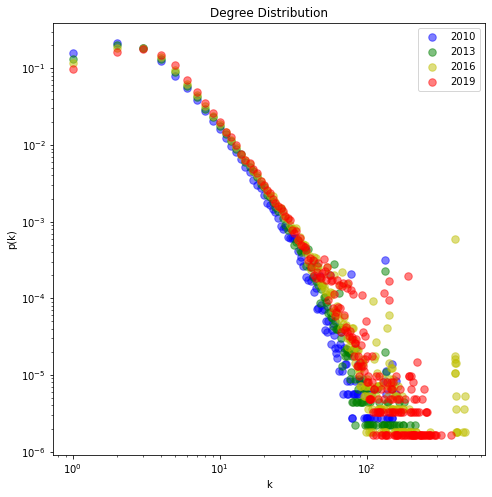

In [75]:
degree_probs = plot_degree_dist_from_dict(degree_probs)

In [76]:
def plot_mult_degree_dist(degree_probs):
    fig, axs = plt.subplots(1, 4, sharex=True, sharey=True, figsize=(18, 6))
    i,j = 0,0
    
    for key in degree_probs.keys(): 
        axs[i].loglog(np.arange(degree_probs[key].shape[0]), degree_probs[key], 'b.', markersize=15, alpha=0.5)
        axs[i].set_title('Degree Distribution ' + key)
        axs[i].set_xlabel('k')
        axs[i].set_ylabel('p(k)')
        
        i+=1
            
    plt.tight_layout()
    plt.show()

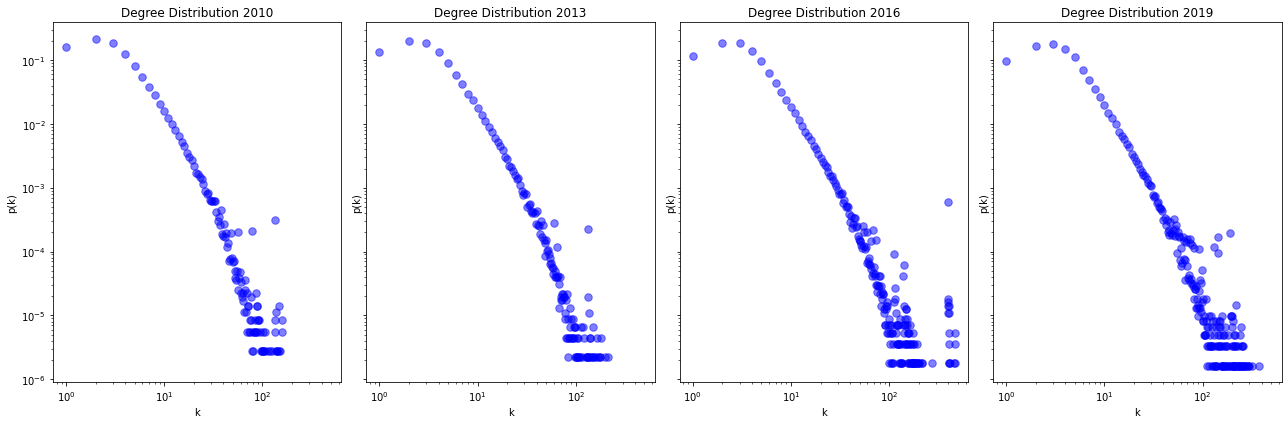

In [77]:
plot_mult_degree_dist(degree_probs)

In [78]:
def plot_degree_dist(G):
    degree_hist = nx.degree_histogram(G) 
    degree_hist = np.array(degree_hist, dtype=float)
    degree_prob = degree_hist/G.number_of_nodes()
    
    # plotting
    fig = plt.figure(figsize=(6,6))
    axes = fig.add_axes([1,1,1,1])
    
    axes.loglog(np.arange(degree_prob.shape[0]), degree_prob, 'b.', markersize=15, alpha=0.5)
    
    axes.set_xlabel('k')
    axes.set_ylabel('p(k)')
    axes.set_title('Degree Distribution')
    
    plt.show()

In [132]:
G = G_2019

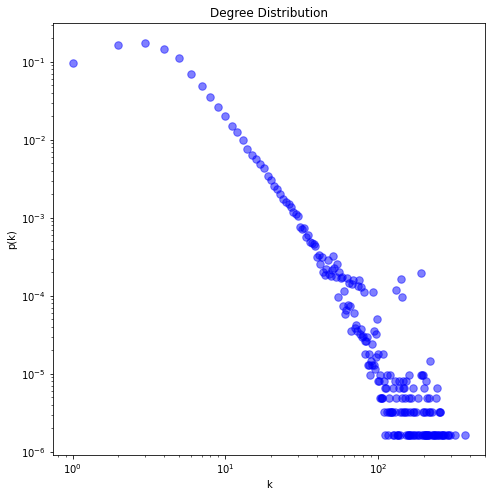

In [80]:
plot_degree_dist(G)

## Path length

In [81]:
def get_length(G):
    if nx.is_connected(G):
        print (nx.average_shortest_path_length(G))
    else:
        print ('Graph not connected: infinite path length')
        
get_length(G)

Graph not connected: infinite path length


## Clustering coefficient

In [82]:
print (nx.average_clustering(G))

0.7915072799558133


## knn(k)

In [83]:
def fit_func(x,a,mu):
    return (a*x)**mu

In [86]:
def plot_knn(G, fit=True): 
    knn_dict = nx.k_nearest_neighbors(G) # k_nearest_neighbors return dict with knn for each k
    k_lst = sorted(knn_dict.keys())
    knn_lst = []
    for k in k_lst:
        knn_lst.append(knn_dict[k])
    
    # plotting
    fig = plt.figure(figsize=(6,6))
    axes = fig.add_axes([1,1,1,1])
    
    axes.loglog(k_lst,knn_lst,'b.', markersize=15, alpha=0.5)
    
    axes.set_xlabel('k')
    axes.set_ylabel('knn(k)')
    axes.set_title('Average next neighbor degree')
    
    if fit:
        # fit a*x^mu
        popt, pcov = curve_fit(fit_func, np.array(k_lst), np.array(knn_lst))
        axes.loglog(np.array(k_lst), fit_func(np.array(k_lst), *popt), '--', c='gray')
    
    plt.show()

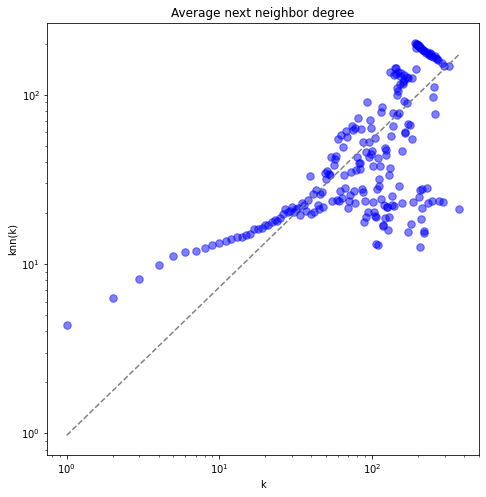

In [87]:
plot_knn(G)

in assortative networks hubs tend to connect to other hubs, hence the
higher is the degree k of a node, the higher is the average degree of
its nearest neighbors. Consequently for assortative networks knn(k)
increases with k, as observed for scientific collaboration networks

## snn(k)

In [116]:
def plot_snn(G, fit=True): 
    knn_dict = nx.k_nearest_neighbors(G, weight='weight') # k_nearest_neighbors return dict with knn for each k
    k_lst = sorted(knn_dict.keys())
    knn_lst = []
    for k in k_lst:
        knn_lst.append(knn_dict[k])
    
    # plotting
    fig = plt.figure(figsize=(6,6))
    axes = fig.add_axes([1,1,1,1])
    
    axes.loglog(k_lst,knn_lst,'b.', markersize=15, alpha=0.5)
    
    axes.set_xlabel('k')
    axes.set_ylabel('snn(k)')
    axes.set_title('Average next neighbor degree')
    
    if fit:
        # fit a*x^mu
        popt, pcov = curve_fit(fit_func, np.array(k_lst), np.array(knn_lst))
        axes.loglog(np.array(k_lst), fit_func(np.array(k_lst), *popt), '--', c='gray')
    
    plt.show()

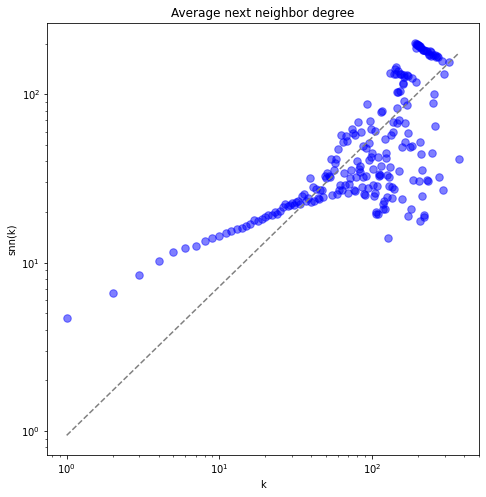

In [117]:
plot_snn(G)

## Average clustering coefficient C(k)

In [4]:
def plot_clustering_coefficient(G):
    clustering_dict = {}
    for node in G.nodes():
        k = G.degree(node)
        if not k in clustering_dict:
            clustering_dict[k] = [nx.clustering(G,node)]
        else:
            clustering_dict[k].append(nx.clustering(G,node))
    k_lst = sorted(clustering_dict.keys())
    clustering_lst = []
    for k in k_lst:
        clustering_lst.append(np.array(clustering_dict[k]).mean())
    
    # plotting
    fig = plt.figure(figsize=(6,6))
    axes = fig.add_axes([1,1,1,1])
    
    axes.loglog(k_lst,clustering_lst,'b.', markersize=15, alpha=0.5)
        
    axes.set_xlabel('k')
    axes.set_ylabel('C(k)')
    axes.set_title('Average clustering coefficient')
    
    plt.show()

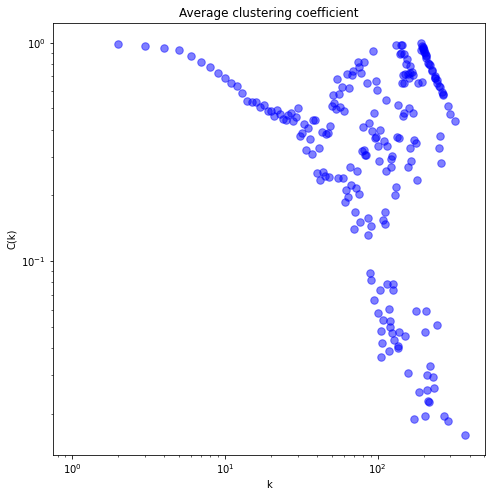

In [89]:
plot_clustering_coefficient(G)

In [90]:
print ('Size of largest component: %s' % len(max(nx.connected_components(G), key=len)))
print ('Degree Assortativity Coefficient (r): %s' % nx.degree_assortativity_coefficient(G))

Size of largest component: 343021
Degree Assortativity Coefficient (r): 0.7054521525008601


hierarchical network, class6:  when K goes up , clustering coeff goes down, which means - on high degrees the neighbors are not connected to each other

## weight dist

In [91]:
def plot_weight_dist(G): 
    weight_lst = list(nx.get_edge_attributes(G,'weight').values())
    max_val = max(weight_lst)
    weight_hist = np.histogram(weight_lst, np.arange(max_val+2))[0]
    weight_hist = weight_hist.astype('float64')
    weight_prob = weight_hist/len(weight_lst)
    
    # plotting
    fig = plt.figure(figsize=(6,6))
    axes = fig.add_axes([1,1,1,1])
    
    axes.loglog(np.arange(weight_prob.shape[0]), weight_prob, 'b.', markersize=15, alpha=0.5)
    
    axes.set_xlabel('w')
    axes.set_ylabel('p(w)')
    axes.set_title('Weight Distribution')
    
    plt.show()

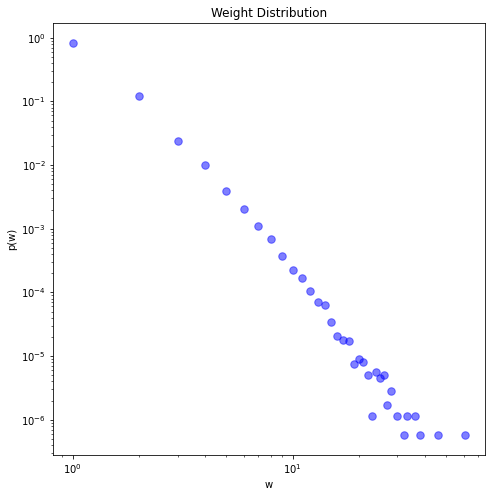

In [92]:
plot_weight_dist(G)

## strength dist

In [93]:
def plot_strength_dist(G):
    strength_lst = list(dict(G.degree(weight='weight')).values())
    max_val = max(strength_lst)
    strength_hist = np.histogram(strength_lst, np.arange(max_val+2))[0]
    strength_hist = strength_hist.astype('float64')
    strength_prob = strength_hist/len(strength_lst)
    
    # plotting
    fig = plt.figure(figsize=(6,6))
    axes = fig.add_axes([1,1,1,1])
    
    axes.loglog(np.arange(strength_prob.shape[0]), strength_prob, 'b.', markersize=15, alpha=0.5)
    
    axes.set_xlabel('s')
    axes.set_ylabel('p(s)')
    axes.set_title('Strength Distribution')
    
    plt.show()

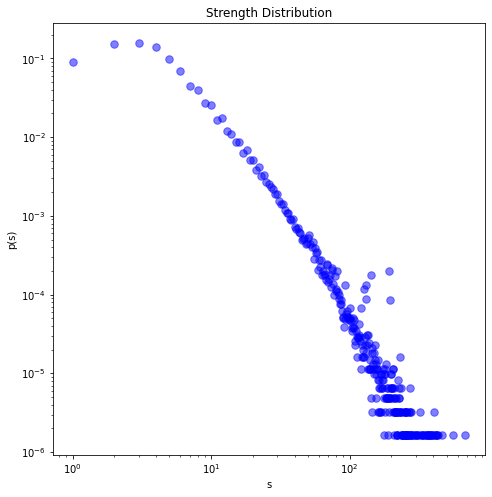

In [94]:
plot_strength_dist(G)

In [134]:
def plot_k_vs_s(G):
    
    fig = plt.figure(figsize=(6,6))
    axes = fig.add_axes([1,1,1,1])
    
    axes.loglog(list(dict(sorted(dict(G.degree()).items())).values()), 
                list(dict(sorted(dict(G.degree(weight='weight')).items())).values()), 
                'b.', markersize=15, alpha=0.5)
    
    axes.loglog(list(dict(sorted(dict(G.degree()).items())).values()), 
                list(dict(sorted(dict(G.degree()).items())).values()), 
                'red', markersize=25, alpha=1)
    
    axes.set_xlabel('k')
    axes.set_ylabel('s')
    axes.set_title('degree vs. strength')
    
    plt.show()

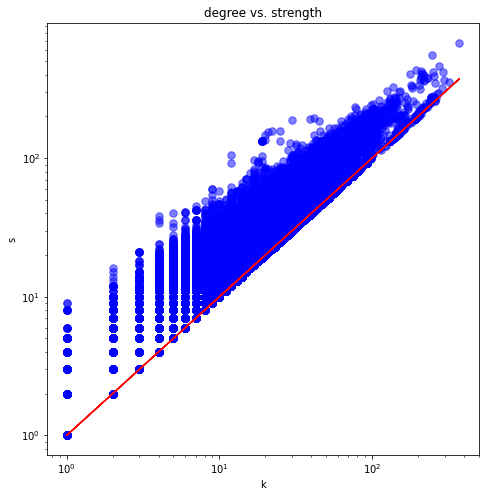

In [135]:
plot_k_vs_s(G)

In [144]:
a = list(dict(sorted(dict(G.degree()).items())).values())
b = list(dict(sorted(dict(G.degree(weight='weight')).items())).values())
print(len(a), len(b))

613406 613406


In [146]:
from scipy.stats import pearsonr
pearsonr(a, b)

(0.9361541801333131, 0.0)

when number of collaborations goes higher(k), number of repeated collaborations also goes higher(s)

## Num of papers vs. Num of collabs 

In [124]:
def plot_num_papers_vs_collabs(deg_df):
    fig = plt.figure(figsize=(6,6))
    axes = fig.add_axes([1,1,1,1])

    axes.loglog(deg_df['num_papers'].values, deg_df['degree'].values, 
                'b.', markersize=15, alpha=0.5)
    
    axes.loglog(deg_df['num_papers'].values, deg_df['num_papers'].values, 
                'red', markersize=25, alpha=1)
    
    axes.set_xlabel('# papers in 2019')
    axes.set_ylabel('# Average collaborations')


    plt.show()

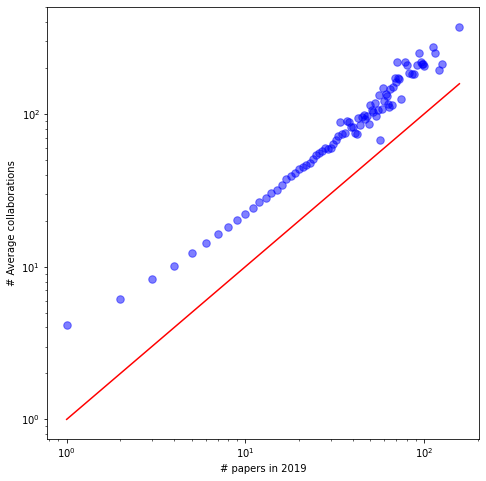

In [125]:
df_t = pd.read_csv('2019_authors_names.csv')

deg_df = pd.DataFrame(dict(G.degree()).items(), columns=['author_id', 'degree'])
deg_df = deg_df.merge(df_t[['author_id','num_papers']], how='left', on='author_id')

deg_df = deg_df.groupby('num_papers').mean().reset_index()

plot_num_papers_vs_collabs(deg_df)

## centrality ## 

In [65]:
# deg_cntr = OrderedDict(sorted(dict(nx.degree_centrality(G)).items(), key = itemgetter(1), reverse = True))
# print(list(deg_cntr.items())[:5])

# cls_cntr = OrderedDict(sorted(dict(nx.closeness_centrality(G)).items(), key = itemgetter(1), reverse = True))
# print(list(cls_cntr.items())[:5])

# btwn_cntr = OrderedDict(sorted(dict(nx.betweenness_centrality(G)).items(), key = itemgetter(1), reverse = True))
# print(list(btwn_cntr.items())[:5])


In [101]:
G.degree(2109386830)

374

In [102]:
d = OrderedDict(sorted(dict(G.degree()).items(), key = itemgetter(1), reverse = True))
list(d.items())[:10]

[(2109386830, 374),
 (2282936248, 321),
 (2046771686, 296),
 (2156575750, 290),
 (2141862317, 287),
 (2116008403, 274),
 (2569344664, 269),
 (2094915095, 267),
 (575195435, 264),
 (47842845, 259)]

## TLV Case Study Analysis ##

In [3]:
df_tlv = pd.read_csv('tlv_edges.csv')
g_tlv = nx.from_pandas_edgelist(df_tlv,'Source','Target', edge_attr='weight')

print (nx.info(g_tlv))

Name: 
Type: Graph
Number of nodes: 963
Number of edges: 1234
Average degree:   2.5628


In [104]:
d_tlv = OrderedDict(sorted(dict(g_tlv.degree()).items(), key = itemgetter(1), reverse = True))
list(d_tlv.items())[:10]

[(9988965, 61),
 (580757126, 36),
 (2294996757, 28),
 (2059111593, 27),
 (1345056057, 21),
 (9985198, 20),
 (1983463915, 20),
 (1981053164, 20),
 (2078633956, 19),
 (687553606, 19)]

In [105]:
list(g_tlv.edges(1345056057))

[(1345056057, 91343107),
 (1345056057, 131349027),
 (1345056057, 172841154),
 (1345056057, 719828399),
 (1345056057, 2036035498),
 (1345056057, 2096398445),
 (1345056057, 2103239820),
 (1345056057, 2105628737),
 (1345056057, 2132478116),
 (1345056057, 2144636783),
 (1345056057, 2144725603),
 (1345056057, 2224265930),
 (1345056057, 2229511016),
 (1345056057, 2397876722),
 (1345056057, 2489583241),
 (1345056057, 2570290309),
 (1345056057, 2832588412),
 (1345056057, 2944170742),
 (1345056057, 2944446064),
 (1345056057, 2951021728),
 (1345056057, 2953735065)]

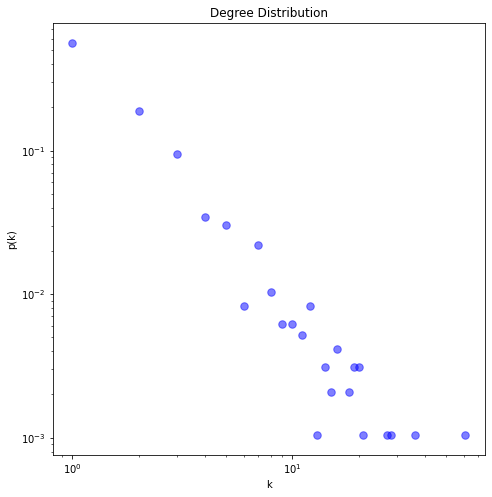

In [106]:
plot_degree_dist(g_tlv)

In [107]:
tlv_deg_cntr = OrderedDict(sorted(dict(nx.degree_centrality(g_tlv)).items(), key = itemgetter(1), reverse = True))
print('TLV degree centrality:')
print(list(tlv_deg_cntr.items())[:10])

tlv_cls_cntr = OrderedDict(sorted(dict(nx.closeness_centrality(g_tlv)).items(), key = itemgetter(1), reverse = True))
print('TLV closeness centrality:')
print(list(tlv_cls_cntr.items())[:5])

tlv_btwn_cntr = OrderedDict(sorted(dict(nx.betweenness_centrality(g_tlv)).items(), key = itemgetter(1), reverse = True))
print('TLV betweenness centrality:')
print(list(tlv_btwn_cntr.items())[:5])


TLV degree centrality:
[(9988965, 0.06340956340956341), (580757126, 0.037422037422037424), (2294996757, 0.029106029106029108), (2059111593, 0.028066528066528068), (1345056057, 0.02182952182952183), (9985198, 0.02079002079002079), (1983463915, 0.02079002079002079), (1981053164, 0.02079002079002079), (2078633956, 0.01975051975051975), (687553606, 0.01975051975051975)]
TLV closeness centrality:
[(839208152, 0.0659430537479318), (2078633956, 0.06588353835646255), (2114518581, 0.06314788970498313), (9988965, 0.06137439571174511), (80354510, 0.059252403002403)]
TLV betweenness centrality:
[(2078633956, 0.04152199105372885), (839208152, 0.041045327725868795), (1484279603, 0.03100186554921206), (1252131916, 0.029766579194258694), (80354510, 0.029530050341704868)]


In [108]:
get_length(g_tlv)

Graph not connected: infinite path length


In [109]:
print (nx.average_clustering(g_tlv))

0.29949859836416515


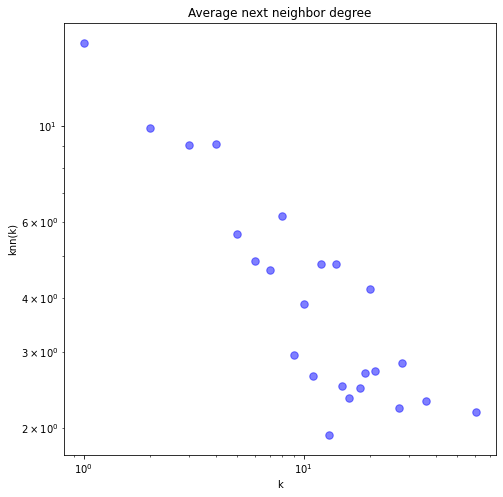

In [110]:
plot_knn(g_tlv,fit=False)

In [111]:
print ('Degree Assortativity Coefficient (r): %s' % nx.degree_assortativity_coefficient(g_tlv))

Degree Assortativity Coefficient (r): -0.2682346584697883


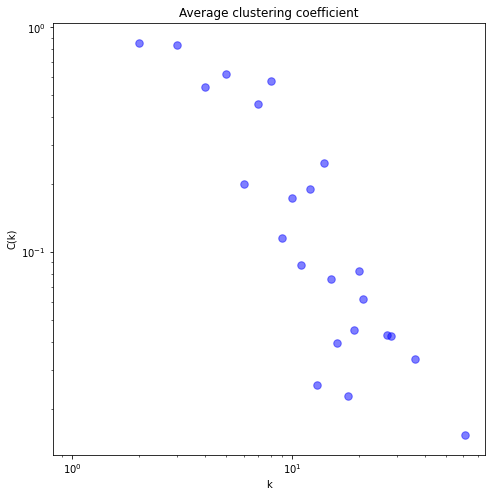

In [5]:
plot_clustering_coefficient(g_tlv)

In [6]:
print (nx.average_clustering(g_tlv))

0.29949859836416515
